In [1]:
"""
We want to recreate f160w using the results from f140w:
    - take light and lens model from this
    - convolve with the psf of f160w
    - scale light profiles by a factor to fit with f160w
    - check residual
"""

'\nWe want to recreate f160w using the results from f140w:\n    - take light and lens model from this\n    - convolve with the psf of f160w\n    - scale light profiles by a factor to fit with f160w\n    - check residual\n'

In [2]:
from tools import *
from get_res import *
from create_fits import *
from input_data import init_kwrg_data
from image_manipulation import create_mask

import numpy as np
from copy import copy 
import matplotlib.pyplot as plt

In [73]:
#F160W = "f160w" # "f160w_7040"
F160W = "f160w_7030"


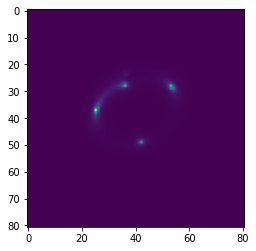

In [74]:
# f140w_CP_logL2_SC_I is the reference
sl_f140 = source_light("f140w")
plt.imshow(sl_f140)
plt.show()

In [75]:

def get_bandmodel_given_model(setting_image,setting_model):
    kwargs_model     = get_kwargs_model(setting_model)
    kwargs_data,mask = init_kwrg_data(setting_image,return_mask=True)
    kwargs_numerics  = init_kwrg_numerics(setting_image)
    kwargs_psf       = init_kwrg_psf(setting_image,saveplots=False)
    multi_band_list  = [[kwargs_data, kwargs_psf, kwargs_numerics]]
    image_likelihood_mask_list = [mask.tolist()]
    bandmodel = SingleBandMultiModel(multi_band_list, kwargs_model, likelihood_mask_list=image_likelihood_mask_list,band_index=0)
    return bandmodel

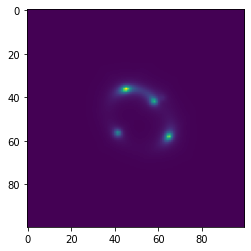

In [76]:
bandmod_f160    = get_bandmodel_given_model(setting_image=F160W,setting_model="f140w")
sl_f140_f160bndm = source_light("f140w",bandmodel=bandmod_f160,unconvolved=False)
plt.imshow(sl_f140_f160bndm)
plt.show()

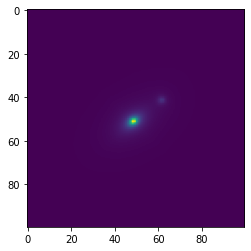

In [77]:
ll_f140_f160bndm = lens_light("f140w",bandmodel=bandmod_f160,unconvolved=False)
plt.imshow(ll_f140_f160bndm)
plt.show()

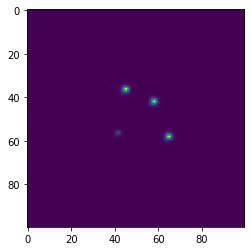

In [78]:
ps_f140_f160bndm = ps_light("f140w",bandmodel=bandmod_f160,unconvolved=False)
plt.imshow(ps_f140_f160bndm)
plt.show()

In [79]:
f160w_data = init_kwrg_data(F160W)
err_f160w  = f160w_data["noise_map"]
data_f160w = f160w_data["image_data"]


In [80]:
mask = create_mask(data_f160w ,setting=F160W)
mask_none = copy(mask)
mask_none[np.where(mask==0)] = None

In [81]:
def create_mod_f160w(fact_ps=1,fact_sl=1,fact_ll=1):
    return (sl_f140_f160bndm*fact_sl)+(ps_f140_f160bndm*fact_ps)+(ll_f140_f160bndm*fact_ll)
def diff_mod(fact_ps=1,fact_sl=1,fact_ll=1):
    return np.abs(create_mod_f160w(fact_ps,fact_sl,fact_ll)-data_f160w)

In [82]:
"""fct_ps = np.arange(.45,.6,0.00001)
fct_sl = np.arange(.2,.5,0.00001)
fct_ll = np.arange(.72,.8,0.00001)

 
to_min_val_ps = np.array([np.nansum(mask_none*diff_mod(fact_ps=f)) for f in fct_ps])
fct_ps_min    = fct_ps[to_min_val_ps.argmin()]
print("point source fact minimised")
to_min_val_sl = np.array([np.nansum(mask_none*diff_mod(fact_sl=f,fact_ps=fct_ps_min)) for f in fct_sl])
fct_sl_min    = fct_sl[to_min_val_sl.argmin()]
print("Source light fact minimised")
to_min_val_ll = np.array([np.nansum(mask_none*diff_mod(fact_ll=f,fact_sl=fct_sl_min,fact_ps=fct_ps_min)) for f in fct_ll])
fct_ll_min    = fct_ll[to_min_val_ll.argmin()]
print("Lens light fact minimised")

mod_f160w = create_mod_f160w(fact_ps=fct_ps_min,fact_sl=fct_sl_min,fact_ll=fct_ll_min)
"""


'fct_ps = np.arange(.45,.6,0.00001)\nfct_sl = np.arange(.2,.5,0.00001)\nfct_ll = np.arange(.72,.8,0.00001)\n\n \nto_min_val_ps = np.array([np.nansum(mask_none*diff_mod(fact_ps=f)) for f in fct_ps])\nfct_ps_min    = fct_ps[to_min_val_ps.argmin()]\nprint("point source fact minimised")\nto_min_val_sl = np.array([np.nansum(mask_none*diff_mod(fact_sl=f,fact_ps=fct_ps_min)) for f in fct_sl])\nfct_sl_min    = fct_sl[to_min_val_sl.argmin()]\nprint("Source light fact minimised")\nto_min_val_ll = np.array([np.nansum(mask_none*diff_mod(fact_ll=f,fact_sl=fct_sl_min,fact_ps=fct_ps_min)) for f in fct_ll])\nfct_ll_min    = fct_ll[to_min_val_ll.argmin()]\nprint("Lens light fact minimised")\n\nmod_f160w = create_mod_f160w(fact_ps=fct_ps_min,fact_sl=fct_sl_min,fact_ll=fct_ll_min)\n'

In [83]:


def to_min(x):
    f_ps,f_sl,f_ll = x
    return np.nansum(mask_none*diff_mod(fact_ps=f_ps,fact_sl=f_sl,fact_ll=f_ll))


from scipy.optimize import fmin
fct_ps_min,fct_sl_min,fct_ll_min =  fmin(to_min,[.5,1.,.7])
mod_f160w = create_mod_f160w(fact_ps=fct_ps_min,fact_sl=fct_sl_min,fact_ll=fct_ll_min)

Optimization terminated successfully.
         Current function value: 179.571209
         Iterations: 61
         Function evaluations: 114


In [84]:
print(fct_ll_min,fct_sl_min,fct_ps_min)


0.7163124945773718 0.784680265569077 0.6581470087363611


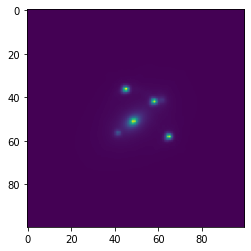

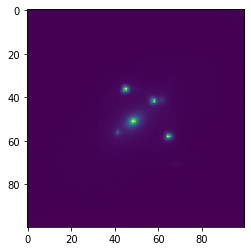

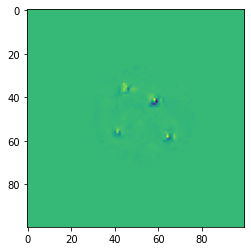

In [85]:
plt.imshow(mod_f160w)
plt.show()
plt.imshow(data_f160w)
plt.show()
plt.imshow(mask*(data_f160w-mod_f160w)/err_f160w)
plt.show()



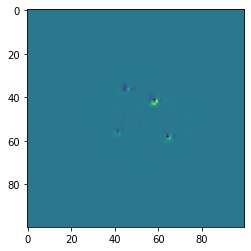

In [86]:
residual = norm_residual(mod_f160w,err_f160w,bandmod_f160)
plt.imshow(residual)
plt.show()


In [87]:
res_dir = "backup_results/mod_"+F160W+"/"
mkdir(res_dir)
setting = get_setting_module(F160W,1)
data_f160w_pth = setting.data_path+setting.image_name
err_file       = setting.data_path+setting.err_name
fits_with_copied_hdr(mod_f160w,fits_parent_path=data_f160w_pth,data_object="Model of F160W from f140W lens model",
                    fits_res_namepath=res_dir+F160W+"_model.fits")
fits_with_copied_hdr(residual,fits_parent_path=data_f160w_pth,data_object="Normalised Residual of Model F160W  from f140W lens model",
                    fits_res_namepath=res_dir+F160W+"_norm_residual.fits")
fits_with_copied_hdr(np.abs(data_f160w-mod_f160w)*mask,fits_parent_path=data_f160w_pth,data_object="Abs. Residual of Model F160W  from f140W lens model",
                    fits_res_namepath=res_dir+F160W+"_abs_residual.fits")


saving file backup_results/mod_f160w_7030/f160w_7030_model.fits
saving file backup_results/mod_f160w_7030/f160w_7030_norm_residual.fits
saving file backup_results/mod_f160w_7030/f160w_7030_abs_residual.fits


0

NameError: name 'get_kwres' is not defined